In [1]:
import cv2
import numpy as np
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import random
%matplotlib inline
custom_style = {'axes.labelcolor': 'white',
                'xtick.color': 'white',
                'ytick.color': 'white'}
sns.set_style("dark", rc=custom_style)
plt.style.use('dark_background')

In [6]:
def addNoise(img, dB=10):
    mu = np.mean(img)
    sigma = np.std(img)
    noise= 10**(-dB/20)*np.reshape([random.gauss(mu, sigma) for i in range(np.size(img))], np.shape(img))
    img_noise = img + noise
    img_noise = (img_noise - img_noise.min()) / (img_noise.max() - img_noise.min()) * 255
    img_noise = np.round(img_noise).astype(np.float32)

    return img_noise

In [8]:
img = cv2.imread("./blood.jpg")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_noise = addNoise(img_gray, dB=3)

# L1正則化

In [9]:
def calcL1(img, alpha=200, lam=30):
    b = img_noise - alpha
    return np.where(np.abs(b) - lam > 0, np.abs(b) - lam, 0) * np.sign(b) + alpha

<Figure size 432x288 with 0 Axes>

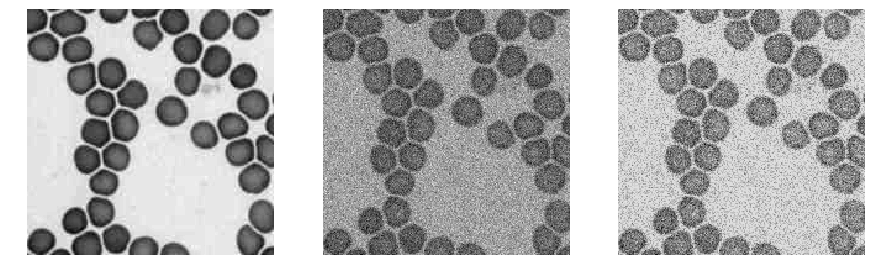

In [10]:
plt.gray()
figs, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].imshow(img_gray)
axs[1].imshow(img_noise)
axs[2].imshow(calcL1(img_noise))

# Split Bregman 

In [11]:
def shrink(img, gamma):
    return np.sign(img) * np.where(np.abs(img) - gamma > 0, np.abs(img) - gamma, 0)

In [12]:
def shrink2(x,y):
    t = np.abs(x) - y
    S = np.sign(x)*(t > 0) * t
    return S

In [13]:
def Gauss_Seidel(img_u, dx, dy, bx, by, img, mu, lam):
    h, w = img_u.shape
    img_u_pad = np.pad(img_u, ((1,1), (1,1)), 'reflect')
    dx_pad = np.pad(dx, ((0,0),(1,0)), 'reflect')
    dy_pad = np.pad(dy, ((1,0),(0,0)), 'reflect')
    bx_pad = np.pad(bx, ((0,0),(1,0)), 'reflect')
    by_pad = np.pad(by, ((1,0),(0,0)), 'reflect')
    
    U = img_u_pad[1:-1, 2:] + img_u_pad[1:-1, :w ] + img_u_pad[2:, 1:-1] + img_u_pad[: h, 1:-1]
    D = dx_pad[:, : -1] - dx_pad[:, 1:] + dy_pad[:-1, :] - dy_pad[1:, :]
    B = -(bx_pad[:, : -1] - bx_pad[:, 1:] + by_pad[:-1, :] - by_pad[1:, :])
    
    return lam / (mu + 4*lam) * (U + D + B) + (mu / (mu + 4*lam)) * img
    

In [14]:
def Gauss_Seidel2(img_u, dx, dy, bx, by, img, mu, lam):
    h, w = img_u.shape
    kernel1 = np.array([[0,1,0],[1,0,1],[0,1,0]])
    kernel2 = np.array([[0,0,0],[1,-1,0],[0,0,0]])
    kernel3 = np.array([[0,1,0],[0,-1,0],[0,0,0]])
    
    U = cv2.filter2D(img_u, -1, kernel1,borderType=cv2.BORDER_REFLECT)
    D = cv2.filter2D(dx, -1, kernel2,borderType=cv2.BORDER_REFLECT) + cv2.filter2D(dy, -1, kernel3,borderType=cv2.BORDER_REFLECT)
    B = -(cv2.filter2D(bx, -1, kernel2,borderType=cv2.BORDER_REFLECT) + cv2.filter2D(by, -1, kernel3,borderType=cv2.BORDER_REFLECT))
    
    return lam / (mu + 4*lam) * (U + D + B) + (mu / (mu + 4*lam)) * img

In [15]:
def initialize(img):
    img_u = img.copy()
    dx = np.zeros(img.shape)
    dy = np.zeros(img.shape)
    bx = np.zeros(img.shape)
    by = np.zeros(img.shape)
    
    return img_u, dx, dy, bx, by 
    

In [16]:
def calcSplitBergman(img, log=True, mu=0.05, lam=0.01, steps=100, tol=0.1):

    img_u, dx, dy, bx, by = initialize(img)
    kernelX = np.array([[0,0,0],
                        [0,-1,1],
                        [0,0,0]])
    kernelY = np.array([[0,0,0],
                        [0,-1,0],
                        [0,1,0]])

    for step in range(steps):
        img_un = Gauss_Seidel2(img_u, dx, dy, bx, by, img, mu, lam)
        err = np.max(img_un - img_u)
        if np.mod(step, 10) == 0 and log==True:
            print("step: {}, error: {}".format(step, err))
        if err > tol:
            img_u = img_un.copy()
#             nabla_xu = np.pad(img_u, ((0,0), (0,1)), 'reflect')[:, 1:] - img_u
#             nabla_yu = np.pad(img_u, ((0,1), (0,0)), 'reflect')[1:, :] - img_u
            nabla_xu = cv2.filter2D(img_u, -1, kernelX,borderType=cv2.BORDER_REFLECT)
            nabla_yu = cv2.filter2D(img_u, -1, kernelY,borderType=cv2.BORDER_REFLECT)
            dx = shrink(nabla_xu + bx, 1 / lam)
            dy = shrink(nabla_yu + by, 1 / lam)
            bx = bx + nabla_xu - dx
            by = by + nabla_yu - dy

        else:
            break
    return img_u


In [17]:
img = cv2.imread("./blood.jpg", 0)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_noise = addNoise(img, dB=3)

<Figure size 432x288 with 0 Axes>

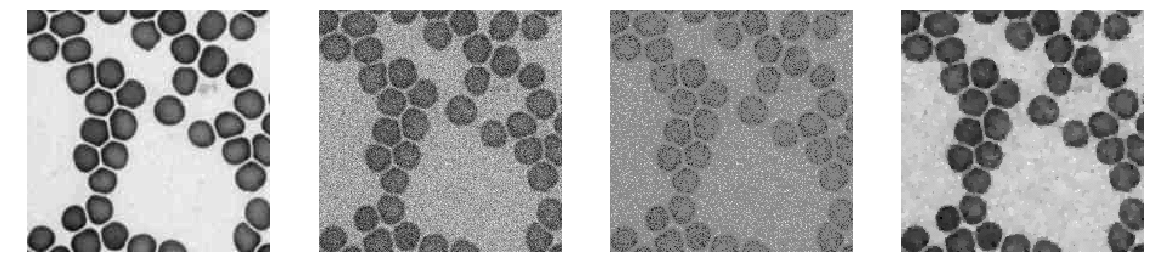

In [18]:
plt.gray()
figs, axs = plt.subplots(1,4, figsize=(20,5))
axs[0].imshow(img_gray)
axs[1].imshow(img_noise)
axs[2].imshow(calcL1(img_noise, alpha=img_noise.mean()).astype(np.int))
axs[3].imshow(calcSplitBergman(img_noise, lam=1, mu=0.07,log=False))

In [19]:
img = cv2.imread("lena.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_noise = addNoise(img, dB=3)

In [20]:
imgBergman = img.copy()
imgBergman[:,:,0] = calcSplitBergman(img_noise[:,:,0])
imgBergman[:,:,1] = calcSplitBergman(img_noise[:,:,1])
imgBergman[:,:,2] = calcSplitBergman(img_noise[:,:,2])

step: 0, error: 41.22222561306424
step: 10, error: 2.9553976584089128
step: 20, error: 1.5137504685213798
step: 30, error: 0.9918219708803235
step: 40, error: 0.8474540416448804
step: 50, error: 0.5332645193770134
step: 60, error: 0.5022421307712932
step: 70, error: 0.3494406922050075
step: 80, error: 0.2817972086235727
step: 90, error: 0.3654343012982224
step: 0, error: 43.44444518619114
step: 10, error: 3.8972834176436493
step: 20, error: 1.6167924716860966
step: 30, error: 0.8791729314399106
step: 40, error: 0.6163210329067113
step: 50, error: 0.5757027938140311
step: 60, error: 0.37928368462337403
step: 70, error: 0.3551426383570231
step: 80, error: 0.3581289952071529
step: 90, error: 0.32912493496436923
step: 0, error: 45.22222264607748
step: 10, error: 3.209275758423132
step: 20, error: 1.2508337489927612
step: 30, error: 0.9450729797321458
step: 40, error: 0.7555845017822946
step: 50, error: 0.5164272675124835
step: 60, error: 0.3645555891510526
step: 70, error: 0.36538119864457

<Figure size 432x288 with 0 Axes>

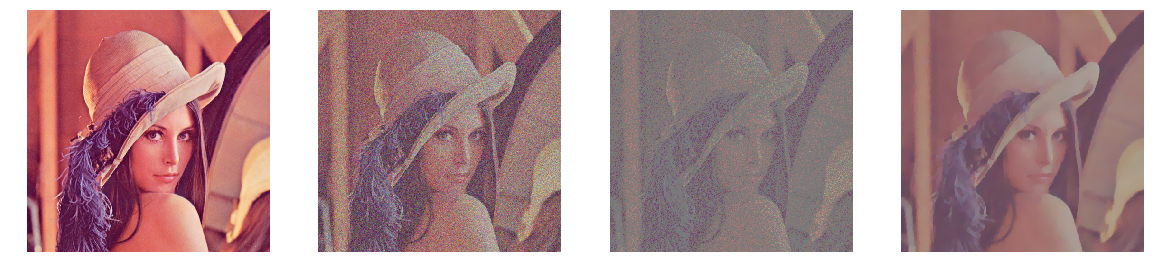

In [21]:
plt.gray()
figs, axs = plt.subplots(1,4, figsize=(20,5))
axs[0].imshow(img)
axs[1].imshow(img_noise.astype(np.int))
axs[2].imshow(calcL1(img_noise, alpha=img_noise.mean()).astype(np.int))
axs[3].imshow(imgBergman)

In [22]:
imgBergmanYCrCb = cv2.cvtColor(imgBergman, cv2.COLOR_RGB2YCrCb)

In [23]:
def getHistFlat(img):
    hist, bins = np.histogram(img.flatten(), 256, [0, 256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()
    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255 / (cdf_m.max() - cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')
    return cdf[img]


In [24]:
imgBergmanYCrCb[:,:,0] = getHistFlat(imgBergmanYCrCb[:,:,0])
# imgBergmanYCrCb[:,:,0] = cv2.equalizeHist(imgBergmanYCrCb[:,:,0])
imgBergman2 = cv2.cvtColor(imgBergmanYCrCb, cv2.COLOR_YCrCb2RGB)

In [25]:
img_at200 = img[200,:,0]
imgNoise_at200 = img_noise[200,:,0]
imgBergman_at200 = imgBergman[200,:,0]

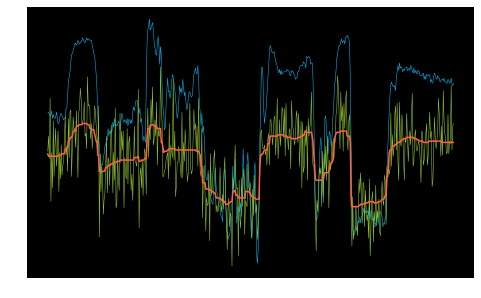

In [26]:
plt.figure(figsize=(8,5))
plt.plot(img_at200, lw = 0.5, color="deepskyblue")
plt.plot(imgNoise_at200, lw = 0.5, color="yellowgreen")
plt.plot(imgBergman_at200, color="tomato")